In [1]:
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>') 

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from local_dotplot_lib import *

trna= "GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
trna2="GGGCUAUUAGCUCAGUUGGUUAGAGCGCACCCCUGAUAAGGGUGAGGUCGCUGAUUCGAAUUCAGCAUAGCCCA"

bpmat = getBPPM(trna)

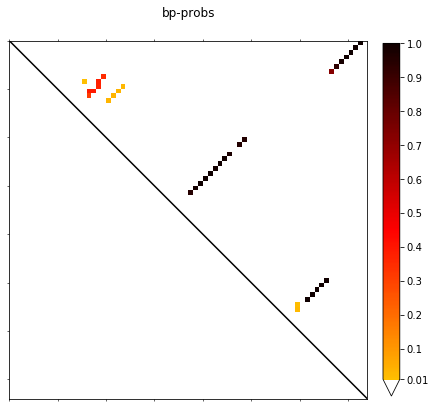

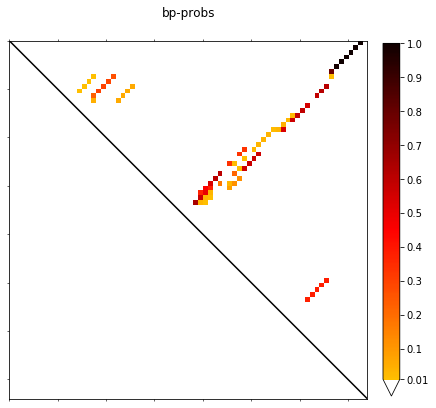

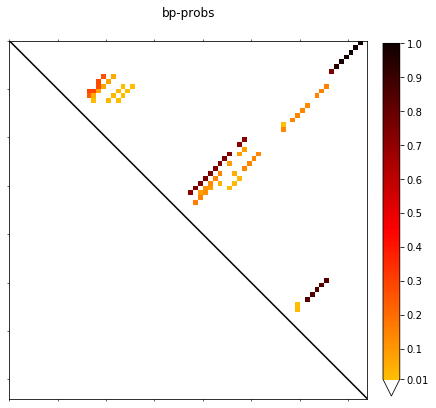

In [17]:
def average_basepair_prob_seqs(seq_arr):
    seq_lengths = [len(s) for s in seq_arr]
    if len(set(seq_lengths)) != 1:
        raise RuntimeError ("Input sequences must have same lenghts found set of lengths:\t{}".format(set(seq_lengths)))
    bpmat_arr = [ getBPPM(s) for s in seq_arr]
    return np.average(bpmat_arr, axis=0)

from Bio import SeqIO
def analyze_average_dps(fasta_file,shuffle=False):
    seqs = [str(s.seq) for s in SeqIO.parse(fasta_file, format='fasta')] 
    if shuffle is True:
        seqs = [dinuclShuffle(s.upper().replace('T','U')) for s in seqs]
        fig_file = fasta_file.replace('fasta','fa').replace('.fa','.shuffled.dp')
    else:
        fig_file = fasta_file.replace('fasta','fa').replace('.fa','.dp')

    plot_heat_maps(None, average_basepair_prob_seqs(seqs), filename=fig_file, what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)
plot_heat_maps(None, getBPPM(trna), filename='/tmp/test.heatmap', what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)
plot_heat_maps(None, getBPPM(trna2), filename='/tmp/test.heatmap', what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)

plot_heat_maps(None, average_basepair_prob_seqs([trna,trna2,trna,trna]), filename='/tmp/test.heatmap', what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)   

In [12]:
np.set_printoptions(suppress=True,precision=3)
bpmat = getBPPM('GCGUGCUGCGC')
print bpmat

[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.106  0.     0.855]
 [ 0.     0.     0.     0.     0.     0.     0.     0.106  0.     0.875  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.04   0.     0.873  0.     0.002]
 [ 0.     0.     0.     0.     0.     0.     0.     0.764  0.     0.002  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.002  0.     0.001]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.001  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]


In [13]:
print (bpmat>0.01 * 1
h = bpmat>0.01
print h
np.average((h),axis=1)

SyntaxError: invalid syntax (<ipython-input-13-b933c9030828>, line 2)

In [14]:
print h
print np.sum(h.astype(int), axis=1)
print np.sum(h.astype(int), axis=0)


NameError: name 'h' is not defined

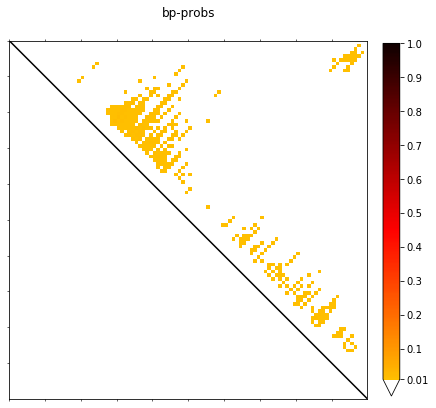

In [18]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-phastcons0.2-mergedoverlaps-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta')

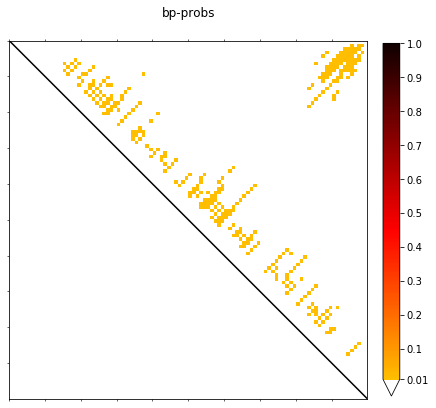

In [19]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-phastcons0.2-mergedoverlaps-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta',shuffle=True)

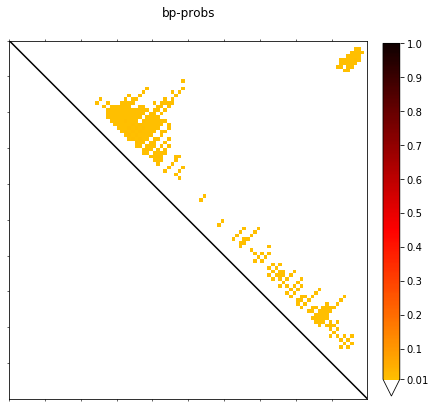

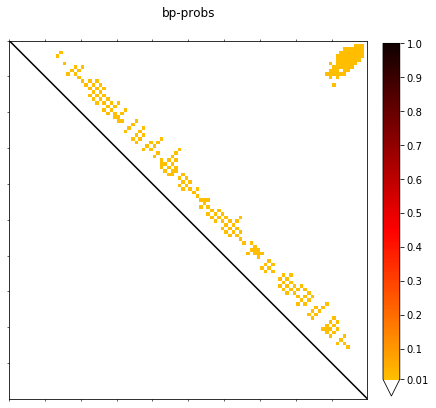

In [20]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-mergedoverlap-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta')
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-mergedoverlap-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta',shuffle=True)


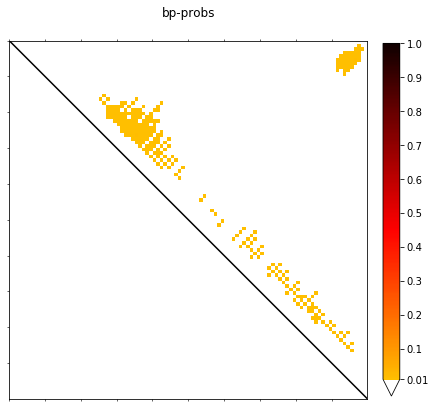

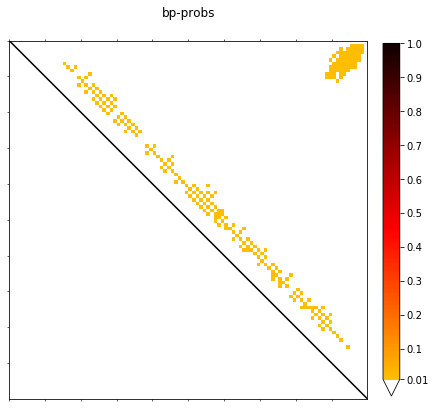

In [21]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Staufen-ALL11k-Galaxy8-[Extract_Genomic_DNA_on_data_3_and_data_7].fasta')
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Staufen-ALL11k-Galaxy8-[Extract_Genomic_DNA_on_data_3_and_data_7].fasta',shuffle=True)


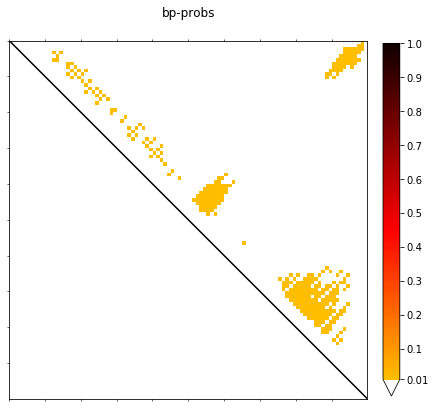

In [22]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Stau-merged-peakcentered-Galaxy2-[Extract_Genomic_DNA_on_data_1].fasta')


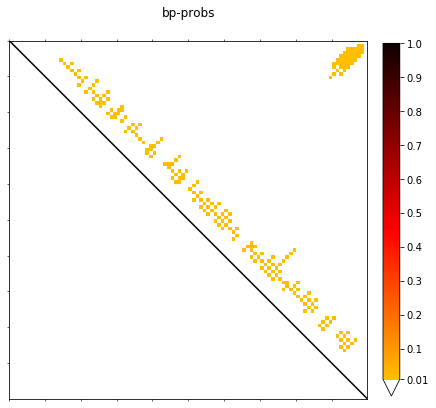

In [23]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Stau-merged-peakcentered-Galaxy2-[Extract_Genomic_DNA_on_data_1].fasta',shuffle=True)


In [83]:
from altschulEriksonDinuclShuffle import dinuclShuffle
dinuclShuffle('CCTGACGTCAGCAGACCGAGACCAGTCCCAGTTCCAGGGGGAGGCCTGCAGGCCCCTGGCCCCTTCCACCACCTCTGCCCTCCGTCTGCAGACCTCGTCC'.replace('T','U'))

'CCGCGGAGCCUCCAGGCACCAGUGGGUCCACUUGUGUGCAGAGACCCCACUGGCCCCCCCCUCUUCCCCAGAGGUCUCUCCAGCAGACUCCGGACUCCGC'

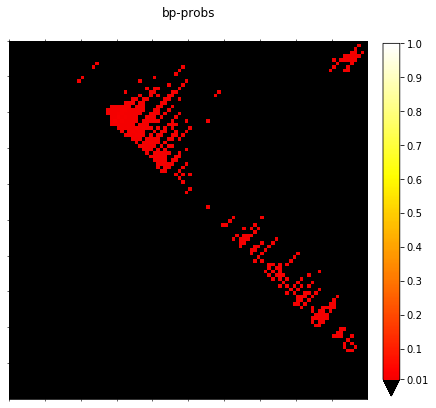

In [49]:
plot_heat_maps(None, average_basepair_prob_seqs(read_seqs[:]), filename='/tmp/test.heatmap', what='basepairs',
                   inverse=False, interactive=False, gene_loc=None)


In [45]:
read_seqs[:10]

['ACCCCTTTCCACCTTTTGTATTTAATTTTAAAGTCAGTGTACTGCAAGGAAGCTGGATGCAAGATAGATACTATATTAAACTGTACTGTTATTTAAGATG',
 'TCTATACAAAACTGTGCTGTGACCTTGCGGTAGGCCTGGATCTGGCAAAGAGAATACAAATGAAACCCCTTCTTTCTCTTTCCGTCCAACAACTCTGTAG',
 'TTTTAATCTCACTTTGGGTTTCCTTGTGAAGTTGGAGGGAAGTTTATAATAGCCTAACACTACCCCACCCCCAACTAGGAGGAACCTCTGTTTTCAAGAG',
 'ATTCCAACTTGGACGCGTTACCATGAGAGCATATCCTATCCAACCGTACTAACGTGGACACCCTACACCTCCCCTCAGAACTTCAAAAGGGCAAGATCTT',
 'TTTTCAGCGACAAGGACCCAGGTCTTCCTGCTGCTGCCAGGGAGAGCAGGGACAGTGCCGCGTGCGAGATGAGCTCGAACACTGCCCGCCTTACTGCCGC',
 'TCTTTGCGGTTGTTCTGTGTGCATGGATTCCACACCTCTGCCGTAGGTAGATCCGTCAGCGGGCATTATTACCGTGTCTTGTAAAGGGTCGGTTTTGTTA',
 'TTTTAACGAAGGGAAAAACAACAGCAATAACATTCATATCTCTGGAGCAGCTAACTCATACACGTAATGTCTGCTTTTCGTACAGAACTAGCCAATGTAA',
 'CGTTCTCGCTTTAAGTCAGGAGTCACAAATGACTTTTTTTTTTCAATTAAGGAAAAAGCTCCATCTCTACCTTTAACATCACCCAGACCCCCGCCCCTGC',
 'ttatCCCTTTAATTAAAGGGAGCAAAGGGGCGTTCCACATGGACAGAGGCTTGGACCGAGGCCTGGTCACAGCAGCGAGCATCCAGGGTTTGCAGGGACG',
 'TTTCCTTGATTTCTCAGTAGGTGCTAGAATCCAGTTCACACCCTTCACTGTGC